In [1]:
import os
import re
import pandas as pd
import nltk
import re
import numpy as np
from pprint import pprint
import gensim # Gensim for Topic Modeling
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy # spaCy for preprocessing
import pyLDAvis # Plotting tools
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter

import string
import copy
import pickle
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Getting all text file location
folder_path = r'C:\Users\yloke\OneDrive\Desktop\TEXT MINING\MINI PROJRCT - 3\Articles'
file_path_folder = []
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        file_path_folder.append(file_path )    
file_path_folder

['C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_ISIS_1.txt',
 'C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_ISIS_10.txt',
 'C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_ISIS_11.txt',
 'C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_ISIS_12.txt',
 'C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_ISIS_2.txt',
 'C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_ISIS_3.txt',
 'C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_ISIS_4.txt',
 'C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_ISIS_5.txt',
 'C:\\Users\\yloke\\OneDrive\\Desktop\\TEXT MINING\\MINI PROJRCT - 3\\Articles\\Articles\\NYT_2017_IS

In [3]:
All_Articles = []
merged_article = ''
for file_path in file_path_folder:    
    with open(file_path, encoding='utf-8-sig') as f:
        content = f.read()
        articles = content.split('\n\n\n')
        for article in articles:
            if 'All Rights Reserved' in article:
                if merged_article:
                    All_Articles.append(merged_article.strip())
                    merged_article = ''
                All_Articles.append(article.strip())
            else:
                merged_article += ' ' + article.strip()
if merged_article:
    All_Articles.append(merged_article.strip())


In [4]:
len(All_Articles)

1691

In [5]:
All_Articles = list(filter(None, All_Articles))
len(All_Articles)

1673

In [6]:
import re

meta_data = []
articles_content = []

for article in All_Articles:
    index = article.find("All Rights Reserved.")
    if index != -1:
        metadata = article[:index+len("All Rights Reserved.")].strip()
        content = article[index+len("All Rights Reserved."):].strip()
    else:
        metadata = article.strip()
        content = ""
    # Remove all non-English letters and newlines from metadata and content
    metadata = re.sub(r'[^a-zA-Z\s\d]+', '', metadata)
    metadata = metadata.replace('\n', ' ').replace('\n\n', ' ')
    content = re.sub(r'[^a-zA-Z\s\d]+', '', content)
    content = content.replace('\n', ' ').replace('\n\n', ' ')
     
    content = ' '.join(content.split()[:-2]) # remove last 2 words from content
    meta_data.append(metadata)
    articles_content.append(content)


In [7]:
articles_content[0]

'ISTANBUL urkish officials accused the United States of abetting a failed coup last summer When the Russian ambassador to Turkey was assassinated last month the Turkish press said the United States was behind the attack And once again after a gunman walked into an Istanbul nightclub early on New Year Day and killed dozens the progovernment news media pointed a finger at the United States merica Chief Suspectne headline blared after the attack On Twitter a Turkish lawmaker referring to the name of the nightclub wrote hoever the triggerman is Reina attack is an act of CIA Period Turkey has been confronted with a cascade of crises that seem to have only accelerated as the Syrian civil war has spilled across the border But the events have not pushed Turkey closer to its NATO allies Conversely they have drifted further apart as the nation lashes out at Washington and moves closer to Moscow working with the Russian president Vladimir V Putin to secure a ceasefire in Syria One story in the Tu

In [8]:
df = pd.DataFrame({'Metadata': meta_data, 'Articles':articles_content})
df

Metadata  \
0     World Europe In Turkey US Hand Is Seen in Near...   
1     World Africa Hymn of Peace by Nigerian Leaders...   
2     Foreign Desk SECTA  ISIS  Member in Germany Is...   
3     World Middle East Suicide Bombing in Baghdad K...   
4     Foreign Desk SECTA Suicide Bombing Kills at Le...   
...                                                 ...   
1668  Tillerson Can End the Qatar Standoff  By Denni...   
1669  US Trump Administration Urges Congress to Reta...   
1670  Markets Iraq Set to Raise 1 Billion in Bond Sa...   
1671  Opinion Tillerson Can End the Qatar Standoff T...   
1672  World WarTorn Syrias Battered Economy Marked b...   

                                               Articles  
0     ISTANBUL urkish officials accused the United S...  
1     As boy bands go it was an unlikely crew In a f...  
2     German prosecutors have added six counts of mu...  
3     BAGHDAD suicide bomber detonated a pickup truc...  
4     BAGHDAD A suicide bomber detonated a pickup tr...  
...                                                 ...  
1668  Defeating Islamic State is the Trump administr...  
1669  WASHINGTONhe Trump administration on Wednesday...  
1670  Iraq is set to raise 1 billion through its fir...  
1671  Defeating Islamic State is the Trump administr...  
1672  After the Syrian government recently introduce...  

[1673 rows x 2 columns]

## Preprocessing

In [9]:
#Removing date that can be any format
import re

for i in range(len(articles_content)):
    # Define regular expressions to match common date formats
    date_formats = [
        r'\d{1,2}\s(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{4}',  # 01 Jan 2022
        r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{1,2},\s\d{4}',  # Jan 01, 2022
        r'\d{1,2}\s(January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}',  # 01 January 2022
        r'(January|February|March|April|May|June|July|August|September|October|November|December)\s\d{1,2},\s\d{4}'  # January 01, 2022
    ]
    # Combine date formats into a single regular expression
    date_regex = '|'.join(date_formats)
    # Remove dates from the current article content
    articles_content[i] = re.sub(date_regex, '', articles_content[i])


In [10]:
corpus = articles_content
corpus[0]

'ISTANBUL urkish officials accused the United States of abetting a failed coup last summer When the Russian ambassador to Turkey was assassinated last month the Turkish press said the United States was behind the attack And once again after a gunman walked into an Istanbul nightclub early on New Year Day and killed dozens the progovernment news media pointed a finger at the United States merica Chief Suspectne headline blared after the attack On Twitter a Turkish lawmaker referring to the name of the nightclub wrote hoever the triggerman is Reina attack is an act of CIA Period Turkey has been confronted with a cascade of crises that seem to have only accelerated as the Syrian civil war has spilled across the border But the events have not pushed Turkey closer to its NATO allies Conversely they have drifted further apart as the nation lashes out at Washington and moves closer to Moscow working with the Russian president Vladimir V Putin to secure a ceasefire in Syria One story in the Tu

In [11]:
len(corpus)

1673

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yloke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yloke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
preprocessed_corpus = []
for document in corpus:
    # Lowercasing
    document = document.lower()
    preprocessed_corpus.append(document)
    


In [14]:
len(preprocessed_corpus)

1673

In [15]:
# Removing punctuation and digits
preprocessed_corpus_P = []
for document in preprocessed_corpus:
    document = ''.join([char for char in document if char.isalpha() or char.isspace()])
    preprocessed_corpus_P.append(document)
    
    

In [16]:

preprocessed_corpus_P[0]

'istanbul urkish officials accused the united states of abetting a failed coup last summer when the russian ambassador to turkey was assassinated last month the turkish press said the united states was behind the attack and once again after a gunman walked into an istanbul nightclub early on new year day and killed dozens the progovernment news media pointed a finger at the united states merica chief suspectne headline blared after the attack on twitter a turkish lawmaker referring to the name of the nightclub wrote hoever the triggerman is reina attack is an act of cia period turkey has been confronted with a cascade of crises that seem to have only accelerated as the syrian civil war has spilled across the border but the events have not pushed turkey closer to its nato allies conversely they have drifted further apart as the nation lashes out at washington and moves closer to moscow working with the russian president vladimir v putin to secure a ceasefire in syria one story in the tu

In [17]:
# Tokenizing
preprocessed_corpus_PT = []
for document in preprocessed_corpus_P:
    tokens = word_tokenize(document)
    preprocessed_corpus_PT.append(tokens)
    
   

In [19]:
preprocessed_corpus_PT[0]

['istanbul',
 'urkish',
 'officials',
 'accused',
 'the',
 'united',
 'states',
 'of',
 'abetting',
 'a',
 'failed',
 'coup',
 'last',
 'summer',
 'when',
 'the',
 'russian',
 'ambassador',
 'to',
 'turkey',
 'was',
 'assassinated',
 'last',
 'month',
 'the',
 'turkish',
 'press',
 'said',
 'the',
 'united',
 'states',
 'was',
 'behind',
 'the',
 'attack',
 'and',
 'once',
 'again',
 'after',
 'a',
 'gunman',
 'walked',
 'into',
 'an',
 'istanbul',
 'nightclub',
 'early',
 'on',
 'new',
 'year',
 'day',
 'and',
 'killed',
 'dozens',
 'the',
 'progovernment',
 'news',
 'media',
 'pointed',
 'a',
 'finger',
 'at',
 'the',
 'united',
 'states',
 'merica',
 'chief',
 'suspectne',
 'headline',
 'blared',
 'after',
 'the',
 'attack',
 'on',
 'twitter',
 'a',
 'turkish',
 'lawmaker',
 'referring',
 'to',
 'the',
 'name',
 'of',
 'the',
 'nightclub',
 'wrote',
 'hoever',
 'the',
 'triggerman',
 'is',
 'reina',
 'attack',
 'is',
 'an',
 'act',
 'of',
 'cia',
 'period',
 'turkey',
 'has',
 'been

In [20]:
 # Removing stop words
preprocessed_corpus_PTS = []
for tokens in preprocessed_corpus_PT:
    tokens = [token for token in tokens if token not in stop_words]
    preprocessed_corpus_PTS.append(tokens)
    
    

In [21]:
preprocessed_corpus_PTS[0]

['istanbul',
 'urkish',
 'officials',
 'accused',
 'united',
 'states',
 'abetting',
 'failed',
 'coup',
 'last',
 'summer',
 'russian',
 'ambassador',
 'turkey',
 'assassinated',
 'last',
 'month',
 'turkish',
 'press',
 'said',
 'united',
 'states',
 'behind',
 'attack',
 'gunman',
 'walked',
 'istanbul',
 'nightclub',
 'early',
 'new',
 'year',
 'day',
 'killed',
 'dozens',
 'progovernment',
 'news',
 'media',
 'pointed',
 'finger',
 'united',
 'states',
 'merica',
 'chief',
 'suspectne',
 'headline',
 'blared',
 'attack',
 'twitter',
 'turkish',
 'lawmaker',
 'referring',
 'name',
 'nightclub',
 'wrote',
 'hoever',
 'triggerman',
 'reina',
 'attack',
 'act',
 'cia',
 'period',
 'turkey',
 'confronted',
 'cascade',
 'crises',
 'seem',
 'accelerated',
 'syrian',
 'civil',
 'war',
 'spilled',
 'across',
 'border',
 'events',
 'pushed',
 'turkey',
 'closer',
 'nato',
 'allies',
 'conversely',
 'drifted',
 'apart',
 'nation',
 'lashes',
 'washington',
 'moves',
 'closer',
 'moscow',
 'w

In [22]:
# Stemming
preprocessed_corpus_PTSS = []
for tokens in preprocessed_corpus_PTS:
    tokens = [porter.stem(token) for token in tokens]  
    preprocessed_corpus_PTSS.append(tokens)



In [23]:
preprocessed_corpus_PTSS[0]

['istanbul',
 'urkish',
 'offici',
 'accus',
 'unit',
 'state',
 'abet',
 'fail',
 'coup',
 'last',
 'summer',
 'russian',
 'ambassador',
 'turkey',
 'assassin',
 'last',
 'month',
 'turkish',
 'press',
 'said',
 'unit',
 'state',
 'behind',
 'attack',
 'gunman',
 'walk',
 'istanbul',
 'nightclub',
 'earli',
 'new',
 'year',
 'day',
 'kill',
 'dozen',
 'progovern',
 'news',
 'media',
 'point',
 'finger',
 'unit',
 'state',
 'merica',
 'chief',
 'suspectn',
 'headlin',
 'blare',
 'attack',
 'twitter',
 'turkish',
 'lawmak',
 'refer',
 'name',
 'nightclub',
 'wrote',
 'hoever',
 'triggerman',
 'reina',
 'attack',
 'act',
 'cia',
 'period',
 'turkey',
 'confront',
 'cascad',
 'crise',
 'seem',
 'acceler',
 'syrian',
 'civil',
 'war',
 'spill',
 'across',
 'border',
 'event',
 'push',
 'turkey',
 'closer',
 'nato',
 'alli',
 'convers',
 'drift',
 'apart',
 'nation',
 'lash',
 'washington',
 'move',
 'closer',
 'moscow',
 'work',
 'russian',
 'presid',
 'vladimir',
 'v',
 'putin',
 'secur',

In [24]:
Cleaned_corpus = []
for tokens in preprocessed_corpus_PTSS:
    tokens = ' '.join(tokens)  # join the words with spaces
    Cleaned_corpus.append(tokens)

In [25]:
Cleaned_corpus[0]

'istanbul urkish offici accus unit state abet fail coup last summer russian ambassador turkey assassin last month turkish press said unit state behind attack gunman walk istanbul nightclub earli new year day kill dozen progovern news media point finger unit state merica chief suspectn headlin blare attack twitter turkish lawmak refer name nightclub wrote hoever triggerman reina attack act cia period turkey confront cascad crise seem acceler syrian civil war spill across border event push turkey closer nato alli convers drift apart nation lash washington move closer moscow work russian presid vladimir v putin secur ceasefir syria one stori turkish press base routin travel warn issu american embassi turkey unit state advanc knowledg nightclub attack islam state later claim respons anoth suggest stun grenad use gunman come stock held american militari still anoth claim assault plot unit state sow divis turkey secular religi rather bring unit state turkey togeth common fight terror nightcl

### These are the  following pre_processing steps

 1.Lower Case the corpus
 
 2.Remove words and puntuation
 
 3.Tokenization
 
 4.Stop words
 
 5.Stemming
 
 

## Extracting Features From articles as bag_of_word

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(Cleaned_corpus)
df_bow = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names())
df_bow

aa  aal  aalla  aamaq  aamur  aana  aap  aara  aaron  aazaldin  ...  \
0      0    0      0      0      0     0    0     0      0         0  ...   
1      0    0      0      0      0     0    0     0      0         0  ...   
2      0    0      0      0      0     0    0     0      0         0  ...   
3      0    0      0      0      0     0    0     0      0         0  ...   
4      0    0      0      0      0     0    0     0      0         0  ...   
...   ..  ...    ...    ...    ...   ...  ...   ...    ...       ...  ...   
1668   0    0      0      0      0     0    0     0      0         0  ...   
1669   0    0      0      0      0     0    0     0      0         0  ...   
1670   0    0      0      0      0     0    0     0      0         0  ...   
1671   0    0      0      0      0     0    0     0      0         0  ...   
1672   0    0      0      0      0     0    0     0      0         0  ...   

      zumba  zurich  zusha  zushaelinsonwsjcom  zuylen  zverev  zvornik  \
0         0       0      0                   0       0       0        0   
1         0       0      0                   0       0       0        0   
2         0       0      0                   0       0       0        0   
3         0       0      0                   0       0       0        0   
4         0       0      0                   0       0       0        0   
...     ...     ...    ...                 ...     ...     ...      ...   
1668      0       0      0                   0       0       0        0   
1669      0       0      0                   0       0       0        0   
1670      0       0      0                   0       0       0        0   
1671      0       0      0                   0       0       0        0   
1672      0       0      0                   0       0       0        0   

      zvulunreut  zway  zy  
0              0     0   0  
1              0     0   0  
2              0     0   0  
3              0     0   0  
4              0     0   0  
...          ...   ...  ..  
1668           0     0   0  
1669           0     0   0  
1670           0     0   0  
1671           0     0   0  
1672           0     0   0  

[1673 rows x 34257 columns]

In [27]:
#Extracting Features
All_features = df_bow.columns
All_features

Index(['aa', 'aal', 'aalla', 'aamaq', 'aamur', 'aana', 'aap', 'aara', 'aaron',
       'aazaldin',
       ...
       'zumba', 'zurich', 'zusha', 'zushaelinsonwsjcom', 'zuylen', 'zverev',
       'zvornik', 'zvulunreut', 'zway', 'zy'],
      dtype='object', length=34257)

In [28]:
import pandas as pd

# Assuming you have a bag-of-words dataframe called "df"
word_freq = df_bow.sum(axis=0)  # Sum the frequency of each word across all documents
top_words = word_freq.nlargest(50)  # Get the top 50 most frequent words
top_words_dict = top_words.to_dict()  # Convert to dictionary


top_words_dict

{'said': 11289,
 'state': 10026,
 'mr': 9802,
 'trump': 7302,
 'islam': 6279,
 'presid': 4476,
 'us': 4318,
 'one': 4149,
 'new': 4133,
 'attack': 4111,
 'american': 4005,
 'time': 3947,
 'peopl': 3933,
 'would': 3810,
 'syria': 3755,
 'unit': 3715,
 'forc': 3658,
 'year': 3365,
 'offici': 3265,
 'group': 3201,
 'militari': 3186,
 'countri': 3124,
 'also': 3036,
 'like': 3000,
 'iraq': 2953,
 'govern': 2756,
 'say': 2735,
 'use': 2703,
 'go': 2681,
 'kill': 2475,
 'citi': 2384,
 'isi': 2356,
 'nation': 2291,
 'syrian': 2289,
 'last': 2253,
 'report': 2249,
 'day': 2234,
 'fight': 2198,
 'secur': 2191,
 'could': 2185,
 'think': 2120,
 'iraqi': 2101,
 'two': 2099,
 'week': 2011,
 'mani': 2005,
 'administr': 1960,
 'get': 1937,
 'even': 1904,
 'want': 1836,
 'back': 1826}

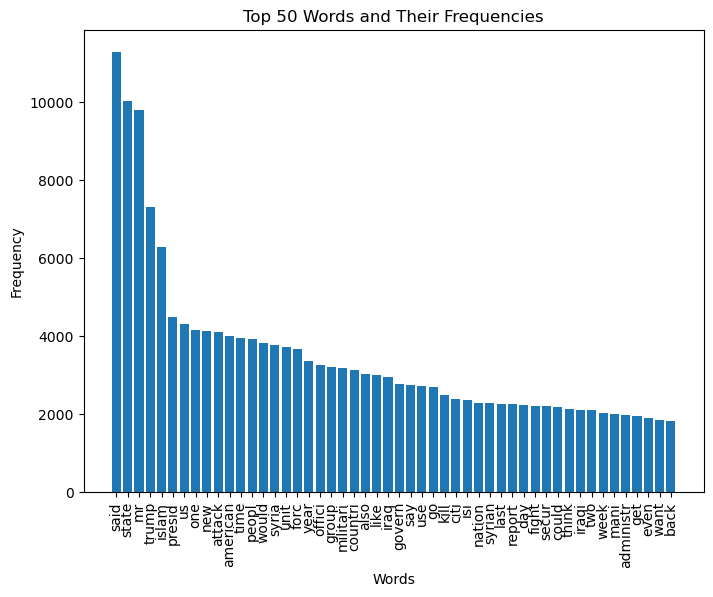

In [29]:
#Bar Graph
# plot a bar chart of the top 50 words and their frequencies
plt.figure(figsize=(8,6))
plt.bar(list(top_words_dict.keys()), list(top_words_dict.values()))
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Words and Their Frequencies')
plt.show()

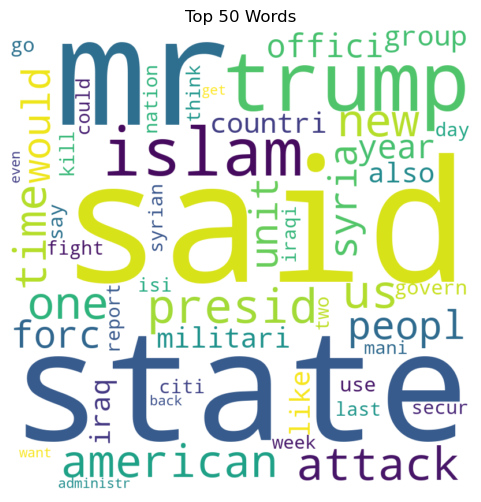

In [30]:
from wordcloud import WordCloud

# create a WordCloud object from the Bag of Words data
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies( top_words_dict)

# plot the WordCloud
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Words')
plt.show()


# PART-2 LDA



In [31]:
len(articles_content)

1673

In [32]:
articles_content[0]

'ISTANBUL urkish officials accused the United States of abetting a failed coup last summer When the Russian ambassador to Turkey was assassinated last month the Turkish press said the United States was behind the attack And once again after a gunman walked into an Istanbul nightclub early on New Year Day and killed dozens the progovernment news media pointed a finger at the United States merica Chief Suspectne headline blared after the attack On Twitter a Turkish lawmaker referring to the name of the nightclub wrote hoever the triggerman is Reina attack is an act of CIA Period Turkey has been confronted with a cascade of crises that seem to have only accelerated as the Syrian civil war has spilled across the border But the events have not pushed Turkey closer to its NATO allies Conversely they have drifted further apart as the nation lashes out at Washington and moves closer to Moscow working with the Russian president Vladimir V Putin to secure a ceasefire in Syria One story in the Tu

In [33]:
# Remove Emails 
data = [re.sub('\S*@\S*\s?', '', sent) for sent in articles_content]  
# Remove new line characters 
data = [re.sub('\s+', ' ', sent) for sent in data]  
# Remove distracting single quotes 
data = [re.sub("\'", "", sent) for sent in data]  
pprint(data[:1])

['ISTANBUL urkish officials accused the United States of abetting a failed '
 'coup last summer When the Russian ambassador to Turkey was assassinated last '
 'month the Turkish press said the United States was behind the attack And '
 'once again after a gunman walked into an Istanbul nightclub early on New '
 'Year Day and killed dozens the progovernment news media pointed a finger at '
 'the United States merica Chief Suspectne headline blared after the attack On '
 'Twitter a Turkish lawmaker referring to the name of the nightclub wrote '
 'hoever the triggerman is Reina attack is an act of CIA Period Turkey has '
 'been confronted with a cascade of crises that seem to have only accelerated '
 'as the Syrian civil war has spilled across the border But the events have '
 'not pushed Turkey closer to its NATO allies Conversely they have drifted '
 'further apart as the nation lashes out at Washington and moves closer to '
 'Moscow working with the Russian president Vladimir V Putin t

In [36]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['istanbul', 'urkish', 'officials', 'accused', 'the', 'united', 'states', 'of', 'abetting', 'failed', 'coup', 'last', 'summer', 'when', 'the', 'russian', 'ambassador', 'to', 'turkey', 'was', 'assassinated', 'last', 'month', 'the', 'turkish', 'press', 'said', 'the', 'united', 'states', 'was', 'behind', 'the', 'attack', 'and', 'once', 'again', 'after', 'gunman', 'walked', 'into', 'an', 'istanbul', 'nightclub', 'early', 'on', 'new', 'year', 'day', 'and', 'killed', 'dozens', 'the', 'progovernment', 'news', 'media', 'pointed', 'finger', 'at', 'the', 'united', 'states', 'merica', 'chief', 'suspectne', 'headline', 'blared', 'after', 'the', 'attack', 'on', 'twitter', 'turkish', 'lawmaker', 'referring', 'to', 'the', 'name', 'of', 'the', 'nightclub', 'wrote', 'hoever', 'the', 'triggerman', 'is', 'reina', 'attack', 'is', 'an', 'act', 'of', 'cia', 'period', 'turkey', 'has', 'been', 'confronted', 'with', 'cascade', 'of', 'crises', 'that', 'seem', 'to', 'have', 'only', 'accelerated', 'as', 'the', '

In [37]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['istanbul', 'urkish', 'officials', 'accused', 'the', 'united_states', 'of', 'abetting', 'failed_coup', 'last', 'summer', 'when', 'the', 'russian', 'ambassador', 'to', 'turkey', 'was', 'assassinated', 'last', 'month', 'the', 'turkish', 'press', 'said', 'the', 'united_states', 'was', 'behind', 'the', 'attack', 'and', 'once', 'again', 'after', 'gunman', 'walked', 'into', 'an', 'istanbul_nightclub', 'early', 'on', 'new', 'year', 'day', 'and', 'killed', 'dozens', 'the', 'progovernment', 'news_media', 'pointed', 'finger', 'at', 'the', 'united_states', 'merica', 'chief', 'suspectne', 'headline', 'blared', 'after', 'the', 'attack', 'on', 'twitter', 'turkish', 'lawmaker', 'referring', 'to', 'the', 'name', 'of', 'the', 'nightclub', 'wrote', 'hoever', 'the', 'triggerman', 'is', 'reina', 'attack', 'is', 'an', 'act', 'of', 'cia', 'period', 'turkey', 'has', 'been', 'confronted', 'with', 'cascade', 'of', 'crises', 'that', 'seem', 'to', 'have', 'only', 'accelerated', 'as', 'the', 'syrian', 'civil_war

In [38]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [39]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['urkish', 'official', 'accuse', 'united_state', 'abet', 'failed_coup', 'last', 'summer', 'russian', 'ambassador', 'assassinate', 'last', 'month', 'turkish', 'say', 'united_state', 'attack', 'gunman', 'walk', 'istanbul_nightclub', 'early', 'new', 'year', 'day', 'kill', 'news', 'medium', 'point', 'finger', 'united_state', 'merica', 'chief', 'suspectne', 'headline', 'blare', 'attack', 'twitter', 'turkish', 'lawmaker', 'refer', 'name', 'nightclub', 'write', 'period', 'turkey', 'confront', 'cascade', 'crisis', 'seem', 'accelerate', 'syrian', 'civil_war', 'spill', 'border', 'event', 'push', 'turkey', 'close', 'ally', 'conversely', 'drift', 'nation', 'lash', 'move', 'close', 'work', 'russian', 'president', 'secure', 'ceasefire', 'story', 'turkish', 'press', 'base', 'routine', 'travel', 'warning', 'issue', 'american', 'embassy', 'turkey', 'united_state', 'advance', 'knowledge', 'state', 'later', 'claimed_responsibility', 'suggest', 'stun', 'grenade', 'use', 'gunman', 'come', 'stock', 'hold',

In [40]:

# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  



In [41]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 3),
  (10, 1),
  (11, 3),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 5),
  (18, 1),
  (19, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 2),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 11),
  (33, 1),
  (34, 2),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 2),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2),
  (51, 2),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 2),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 2),
  (76, 1),
  (77, 1),
  (78, 7),
  (79, 2),
  (80, 3),
  (81, 3),
  (82, 1),
  (83, 1),
  (84, 2),
  (85, 1),
  (86, 1),
  (87, 5),
  (88, 1),
  (89, 2),
  (90, 4),
  (91, 1

In [42]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abet', 1),
  ('ability', 1),
  ('absurd', 1),
  ('absurdity', 1),
  ('academic', 1),
  ('accelerate', 2),
  ('accord', 1),
  ('account', 1),
  ('accumulate', 1),
  ('accuse', 3),
  ('add', 1),
  ('administration', 3),
  ('advance', 1),
  ('aftermath', 1),
  ('agenda', 1),
  ('alarm', 1),
  ('ally', 1),
  ('also', 5),
  ('ambassador', 1),
  ('american', 2),
  ('anonymity', 1),
  ('antiamericanism', 1),
  ('antierdogan', 1),
  ('anxiety', 1),
  ('appear', 2),
  ('army', 1),
  ('arrest', 2),
  ('ask', 1),
  ('assailant', 2),
  ('assassinate', 1),
  ('assault', 1),
  ('assert', 1),
  ('attack', 11),
  ('audience', 1),
  ('authority', 2),
  ('away', 1),
  ('ban', 1),
  ('base', 1),
  ('basically', 1),
  ('beat', 1),
  ('become', 1),
  ('believe', 2),
  ('binali_yildirim', 1),
  ('blame', 2),
  ('blare', 1),
  ('block', 1),
  ('boogeyman', 1),
  ('border', 1),
  ('bosporus', 1),
  ('brief', 1),
  ('bring', 2),
  ('call', 2),
  ('camera', 1),
  ('capstone', 1),
  ('cascade', 1),
  ('cease

In [59]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [60]:

# Extract topics
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.033*"state" + 0.031*"islamic" + 0.031*"say" + 0.028*"force" + '
  '0.019*"syrian" + 0.018*"iraqi" + 0.015*"military" + 0.013*"fight" + '
  '0.013*"city" + 0.013*"fighter"'),
 (1,
  '0.008*"year" + 0.008*"new" + 0.007*"time" + 0.007*"company" + 0.006*"story" '
  '+ 0.006*"day" + 0.006*"show" + 0.005*"business" + 0.005*"look" + '
  '0.005*"make"'),
 (2,
  '0.119*"kurdish" + 0.078*"kurd" + 0.072*"turkish" + 0.041*"turkey" + '
  '0.034*"referendum" + 0.022*"vote" + 0.014*"independence" + '
  '0.014*"withdrawal" + 0.011*"raqqa" + 0.011*"arm"'),
 (3,
  '0.000*"general_mcmaster" + 0.000*"phoenician" + 0.000*"ornamentation" + '
  '0.000*"palmyrene" + 0.000*"panoply" + 0.000*"petra" + 0.000*"orientalist" + '
  '0.000*"polytheistic" + 0.000*"shimmer" + 0.000*"runaway"'),
 (4,
  '0.061*"say" + 0.045*"attack" + 0.028*"kill" + 0.018*"police" + '
  '0.017*"people" + 0.011*"man" + 0.009*"state" + 0.009*"islamic" + '
  '0.009*"official" + 0.009*"authority"'),
 (5,
  '0.030*"child" + 0.029*"f

# Evaluation

In [61]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.730071070849808

Coherence Score:  0.4748409794483799


# Visualize the topics


In [62]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.233794 -0.142251       1        1  23.106968
6      0.275285  0.037439       2        1  17.876099
1      0.199968 -0.114185       3        1  16.246960
0      0.263580  0.103959       4        1  15.994499
4      0.225224  0.153781       5        1   9.153364
15     0.227335 -0.249072       6        1   7.078413
8      0.118407  0.134307       7        1   3.924053
11     0.126050  0.229672       8        1   3.010448
5      0.032450 -0.152154       9        1   2.981055
2     -0.233585  0.008398      10        1   0.485089
12    -0.250985 -0.001515      11        1   0.068160
7     -0.247606 -0.001200      12        1   0.036547
10    -0.239794 -0.002227      13        1   0.025017
9     -0.244156 -0.001564      14        1   0.010565
3     -0.242983 -0.001694      15        1   0.001432
13    -0.242983 -0.001694      16        1   0.001330, topic_info=             Term          Freq         Total Category  logprob  loglift
173       islamic   5107.000000   5107.000000  Default  30.0000  30.0000
329         state   6448.000000   6448.000000  Default  29.0000  29.0000
298           say  15827.000000  15827.000000  Default  28.0000  28.0000
32         attack   4120.000000   4120.000000  Default  27.0000  27.0000
1288        think   2699.000000   2699.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
25           army      0.000327    336.186557  Topic16 -10.3033  -2.6148
26         arrest      0.000327    548.459329  Topic16 -10.3033  -3.1043
27            ask      0.000327   1076.238625  Topic16 -10.3033  -3.7784
28      assailant      0.000327     94.061479  Topic16 -10.3033  -1.3411
29    assassinate      0.000327     22.826591  Topic16 -10.3033   0.0749

[1046 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1423      8  0.954410  abduction
0         1  0.970901       abet
1         1  0.150929    ability
1         2  0.603716    ability
1         4  0.064145    ability
...     ...       ...        ...
1743      3  0.254684      young
1743      5  0.109936      young
1743      9  0.425085      young
5706      6  0.981051  youve_got
3601     10  0.980302        ypg

[1731 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 7, 2, 1, 5, 16, 9, 12, 6, 3, 13, 8, 11, 10, 4, 14])

# Model-2

In [76]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='symmetric',
                                           eta=0.01,
                                           per_word_topics=True)


In [77]:

# Extract topics
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.018*"year" + 0.014*"new" + 0.009*"world" + 0.009*"business" + '
  '0.008*"market" + 0.007*"company" + 0.006*"first" + 0.006*"good" + '
  '0.005*"global" + 0.005*"help"'),
 (1,
  '0.023*"say" + 0.009*"family" + 0.009*"people" + 0.009*"child" + 0.008*"day" '
  '+ 0.008*"man" + 0.008*"tell" + 0.007*"take" + 0.007*"come" + 0.006*"live"'),
 (2,
  '0.048*"syrian" + 0.030*"regime" + 0.020*"attack" + 0.019*"strike" + '
  '0.018*"use" + 0.017*"military" + 0.017*"ally" + 0.015*"iranian" + '
  '0.014*"force" + 0.013*"war"'),
 (3,
  '0.042*"company" + 0.032*"information" + 0.025*"intelligence" + 0.024*"use" '
  '+ 0.020*"facebook" + 0.019*"technology" + 0.017*"report" + 0.013*"content" '
  '+ 0.012*"say" + 0.012*"hack"'),
 (4,
  '0.056*"ankara" + 0.055*"yemeni" + 0.038*"exhibit" + 0.037*"istanbul" + '
  '0.000*"polytheistic" + 0.000*"panoply" + 0.000*"petra" + 0.000*"phoenician" '
  '+ 0.000*"reproduction" + 0.000*"slaughterhouse"'),
 (5,
  '0.144*"book" + 0.077*"novel" + 0.036*"indictme

In [78]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.906008277584863

Coherence Score:  0.4867467530288169


In [79]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.134436 -0.127498       1        1  19.733372
1     -0.142525 -0.048094       2        1  16.214831
7     -0.197927 -0.011967       3        1  14.446964
16    -0.201081  0.181062       4        1   7.602984
0     -0.109145 -0.167831       5        1   6.769269
10    -0.195847  0.180751       6        1   5.891795
15    -0.074655 -0.225824       7        1   5.462507
6     -0.162129  0.040923       8        1   5.350895
2     -0.133951  0.069682       9        1   3.688823
14    -0.134427 -0.089491      10        1   3.468306
18    -0.146652  0.274065      11        1   3.249072
17    -0.152753  0.023433      12        1   2.924550
11    -0.044535 -0.098915      13        1   2.433186
3     -0.043460 -0.164605      14        1   1.946925
13     0.198944  0.063377      15        1   0.376033
19     0.317850  0.028517      16        1   0.138143
5      0.318290  0.009734      17        1   0.135925
12     0.338975  0.024514      18        1   0.076649
8      0.347709  0.021579      19        1   0.062405
4      0.351755  0.016588      20        1   0.027364, topic_info=                Term          Freq         Total Category  logprob  loglift
298              say  16536.000000  16536.000000  Default  30.0000  30.0000
32            attack   4135.000000   4135.000000  Default  29.0000  29.0000
329            state   6604.000000   6604.000000  Default  28.0000  28.0000
173          islamic   5220.000000   5220.000000  Default  27.0000  27.0000
711            iraqi   2047.000000   2047.000000  Default  26.0000  26.0000
..               ...           ...           ...      ...      ...      ...
20         anonymity      0.005486     51.445934  Topic20 -10.5081  -0.9425
21   antiamericanism      0.005486      2.437733  Topic20 -10.5081   2.1070
23           anxiety      0.005486     36.445465  Topic20 -10.5081  -0.5978
24            appear      0.005486    711.637072  Topic20 -10.5081  -3.5695
25              army      0.005486    367.360876  Topic20 -10.5081  -2.9083

[1273 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5211      8  0.990367      abe
0         5  0.944285     abet
1         1  0.141211  ability
1         3  0.553694  ability
1         4  0.152359  ability
...     ...       ...      ...
1743      2  0.636224    young
1743      7  0.223494    young
1743     12  0.138664    young
4552      7  0.995385  youtube
3601      4  1.002172      ypg

[2713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 8, 17, 1, 11, 16, 7, 3, 15, 19, 18, 12, 4, 14, 20, 6, 13, 9, 5])